In [1]:
# 파일 경로 지정
import sys, os
from IPython import get_ipython
notebook_dir = os.path.dirname(os.path.abspath(get_ipython().run_line_magic('pwd', '')))
sys.path.append(notebook_dir)

In [2]:
# 데이터 로드
import pandas as pd
from lib import data_preprocessor

# 데이터 csv를 dataFrame으로 변환
df = data_preprocessor.transform_verilog_results_to_DataFrame('../data/data_unif.csv')
normal_df, data_min, data_max = data_preprocessor.normalize_DataFrame(df)

[] columns are dropped.


In [3]:
# 모델 로드
import torch, joblib
from torch.utils.data import DataLoader
from lib import ANN
from lib import CNN

input_feature = ['i0', 'i62']
output_feature = ['phig', 'cit', 'u0', 'ua', 'eu', 'etamob', 'up', 'rdsw']

ann_model = ANN.ANN(len(input_feature), len(output_feature))
ann_model.load_state_dict(torch.load('../Model/ann_model_weights.pth'))
ann_model.eval()

rf_model = joblib.load('../Model/random_forest_model.pkl')

cnn_model = CNN.CNN(len(input_feature), len(output_feature))
cnn_model.load_state_dict(torch.load('../Model/cnn_model_weights.pt'))
cnn_model.eval()

gbm_model = joblib.load('../Model/gbm_model.pkl')

In [9]:
# 모델 input 데이터 생성
import numpy as np
import pickle, json
from lib import SSHManager, app

# ANN, rf 모델의 input 데이터를 생성한다.
ref_i_on = 1.017694e-04
ref_i_off = 4.597843e-12
mag = np.arange(1.0, 2, 0.05) # 0.05
i_on_with_mag = mag * ref_i_on
i_off_with_mag = mag * ref_i_off

# 모델들을 dict로 저장한다.
model_names = ['ann', 'rf', 'cnn', 'gbm']
models = [ann_model, rf_model, cnn_model, gbm_model]

# 모든 i_on과 i_off쌍을 반환하는 generator를 생성한다.
def get_i_on_i_off_pairs(i_ons, i_offs):
    index = -1
    for i_on in i_ons:
        for i_off in i_offs:
            index += 1
            yield i_on, i_off, index

# 각 모델들의 결과를 저장할 dict를 생성한다.
# 결과를 list로 저장되고, 각 list는 model_names를 key로 한다.
result_parameters: dict = {name: [] for name in model_names}
result_i: dict = {name: [] for name in model_names}

# 그 외 변수 초기화
i_ons = []
i_offs = []

server_info = json.load(open("../server_info.json", "r"))
ssh = SSHManager.SSHManager(server_info["host"], server_info["port"], server_info["id"], server_info["password"])

number_of_parameter = len(output_feature)
i_max = np.array([data_max['i0'], data_max['i62']])
i_min = np.array([data_min['i0'], data_min['i62']])

for model, name in zip(models, model_names):

    print(f"\n\nModel: {name}\n\n")

    # i_ons, i_offs, HSPICE_i를 초기화한다.
    parameters = []
    i_ons = []
    i_offs = []
    HSPICE_i: list = []

    for i_on, i_off, index in get_i_on_i_off_pairs(i_on_with_mag, i_off_with_mag):

        # 모든 i_on, i_off 쌍을 저장한다.
        i_ons.append(i_on)
        i_offs.append(i_off)

        unnormal_i = np.array([i_off, i_on])
        normal_i = (unnormal_i - i_min) / (i_max - i_min)

        # model이 사용된 라이브러리에 따라 다른 input을 사용한다.
        if (name == 'ann') or (name == 'cnn'):
            pred_pytorch = model(torch.tensor(normal_i, dtype=torch.float32).unsqueeze(0))
            pred_pytorch_numpy = pred_pytorch.detach().numpy().squeeze()

            # 결과를 역정규화한다.
            unnormal_pred = pred_pytorch_numpy * (data_max[:number_of_parameter] - data_min[:number_of_parameter]) + data_min[:number_of_parameter]

        # 만약, model이 sklearn 모델이라면,
        elif (name == 'rf') or (name == 'gbm'):
            df = pd.DataFrame([normal_i], columns=input_feature)
            pred_sklearn = model.predict(df)

            # 결과를 역정규화한다.
            unnormal_pred = pred_sklearn[0] * (data_max[:number_of_parameter] - data_min[:number_of_parameter]) + data_min[:number_of_parameter] # rf는 8개의 데이터를 가진 numpy array를 묶어서 반환하기 때문에 [0]을 붙여준다.

        # unnormal_pred를 저장한다.
        parameters.append(unnormal_pred)

        # get_value_with_parameter 함수를 통해 HSPICE를 실행하고 결과 파일을 받는다.
        # 받은 파일 결과는 result에 list 형태로 한 줄씩 저장된다.
        app.get_value_with_parameter(unnormal_pred, ssh, "/home/mario/User/cws/test/")
        with open("result.txt", "r") as f:
            result = f.readlines()

        # HSPICE 실행 결과에서 I_on, I_off 값을 찾아 i_on에 저장한다.
        result_i_on = 0
        result_i_off = 0
        for line in result:
            if 'i0' in line:
                result_i_off = float(line.split()[-1].replace('p', 'e-12'))
            if 'i62' in line:
                result_i_on = float(line.split()[-1].replace('u', 'e-6'))

        HSPICE_i.append([result_i_on, result_i_off])

        # result.txt 파일을 지운다.
        os.remove("result.txt")

        # 만약 index가 0이라면, i_on, i_off, parameter를 출력한다.
        if index == 0:
            print(f'model: {model}')
            print(f'parameters: {unnormal_pred}')
            print(f"i_on, i_off: {i_on}, {i_off}")

    print(f'{name}이 종료됨. 실행 길이: {len(i_ons), len(parameters)}')

    # i_on, i_off에 대한 for문이 종료되면 결과를 저장한다.
    result_parameters[name].append(parameters)
    result_i[name].append(HSPICE_i)

# 서버와의 연결을 종료한다.
ssh.close()



Model: ann


model: ANN(
  (fc1): Linear(in_features=2, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=1000, bias=True)
  (fc4): Linear(in_features=1000, out_features=1000, bias=True)
  (fc5): Linear(in_features=1000, out_features=1000, bias=True)
  (fc6): Linear(in_features=1000, out_features=1000, bias=True)
  (fc7): Linear(in_features=1000, out_features=8, bias=True)
)
parameters: phig      4.479264e+00
cit       2.873178e-04
u0        3.817471e-02
ua        4.530911e-01
eu        6.556403e-01
etamob    7.282409e+00
up        1.014865e-09
rdsw      1.037330e+02
dtype: float64
i_on, i_off: 0.0001017694, 4.597843e-12
ann이 종료됨. 실행 길이: (400, 400)


Model: rf


model: RandomForestRegressor(random_state=42)
parameters: phig      4.479648e+00
cit       2.841870e-04
u0        3.888898e-02
ua        4.768305e-01
eu        6.615466e-01
etamob    8.056825e+00
up        9.920009e-10
rdsw      9.35993

In [ ]:
# 결과를 csv로 저장한다.
# 각 모델 별로 dataFrame을 만들고 합쳐 csv로 저장한다.
results_df = {name: pd.DataFrame() for name in model_names}
for name in model_names:

    print(f"\n\n{name} 결과 저장 중...\n\n")

    # 변수 초기화
    parameters = {}
    i = {}

    # result_parameters의 shape는 (8, 400), result_i의 shape는 (400, 2)임.
    # result_parameters의 첫 차원의 각 원소 (400, )를 column으로 갖는 dataFrame을 만든다.
    parameters[name] = np.array(result_parameters[name]).squeeze()
    i[name] = np.array(result_i[name]).squeeze()
    columns = [column + '_' + name for column in output_feature]
    result_df = pd.DataFrame(parameters[name], columns=columns)

    result_df['i_on_' + name] = np.array(i[name])[:, 0]
    result_df['i_off_' + name] = np.array(i[name])[:, 1]
    results_df[name] = result_df

    # i_on, i_off, parameter의 첫 번째 원소 출력
    print(f"i_on_{name}: {result_df['i_on_' + name][0]}")
    print(f"i_off_{name}: {result_df['i_off_' + name][0]}")
    print(f"parameter_{name}: {result_df.iloc[0]}")

i_on_df = pd.DataFrame(i_ons, columns=['i_on'])
i_off_df = pd.DataFrame(i_offs, columns=['i_off'])

# result_df를 합친다.
result_list = [i_on_df] + [i_off_df] + [results_df[name] for name in model_names]
result_df = pd.concat(result_list, axis=1)
result_df.to_csv('result.csv', index=False)

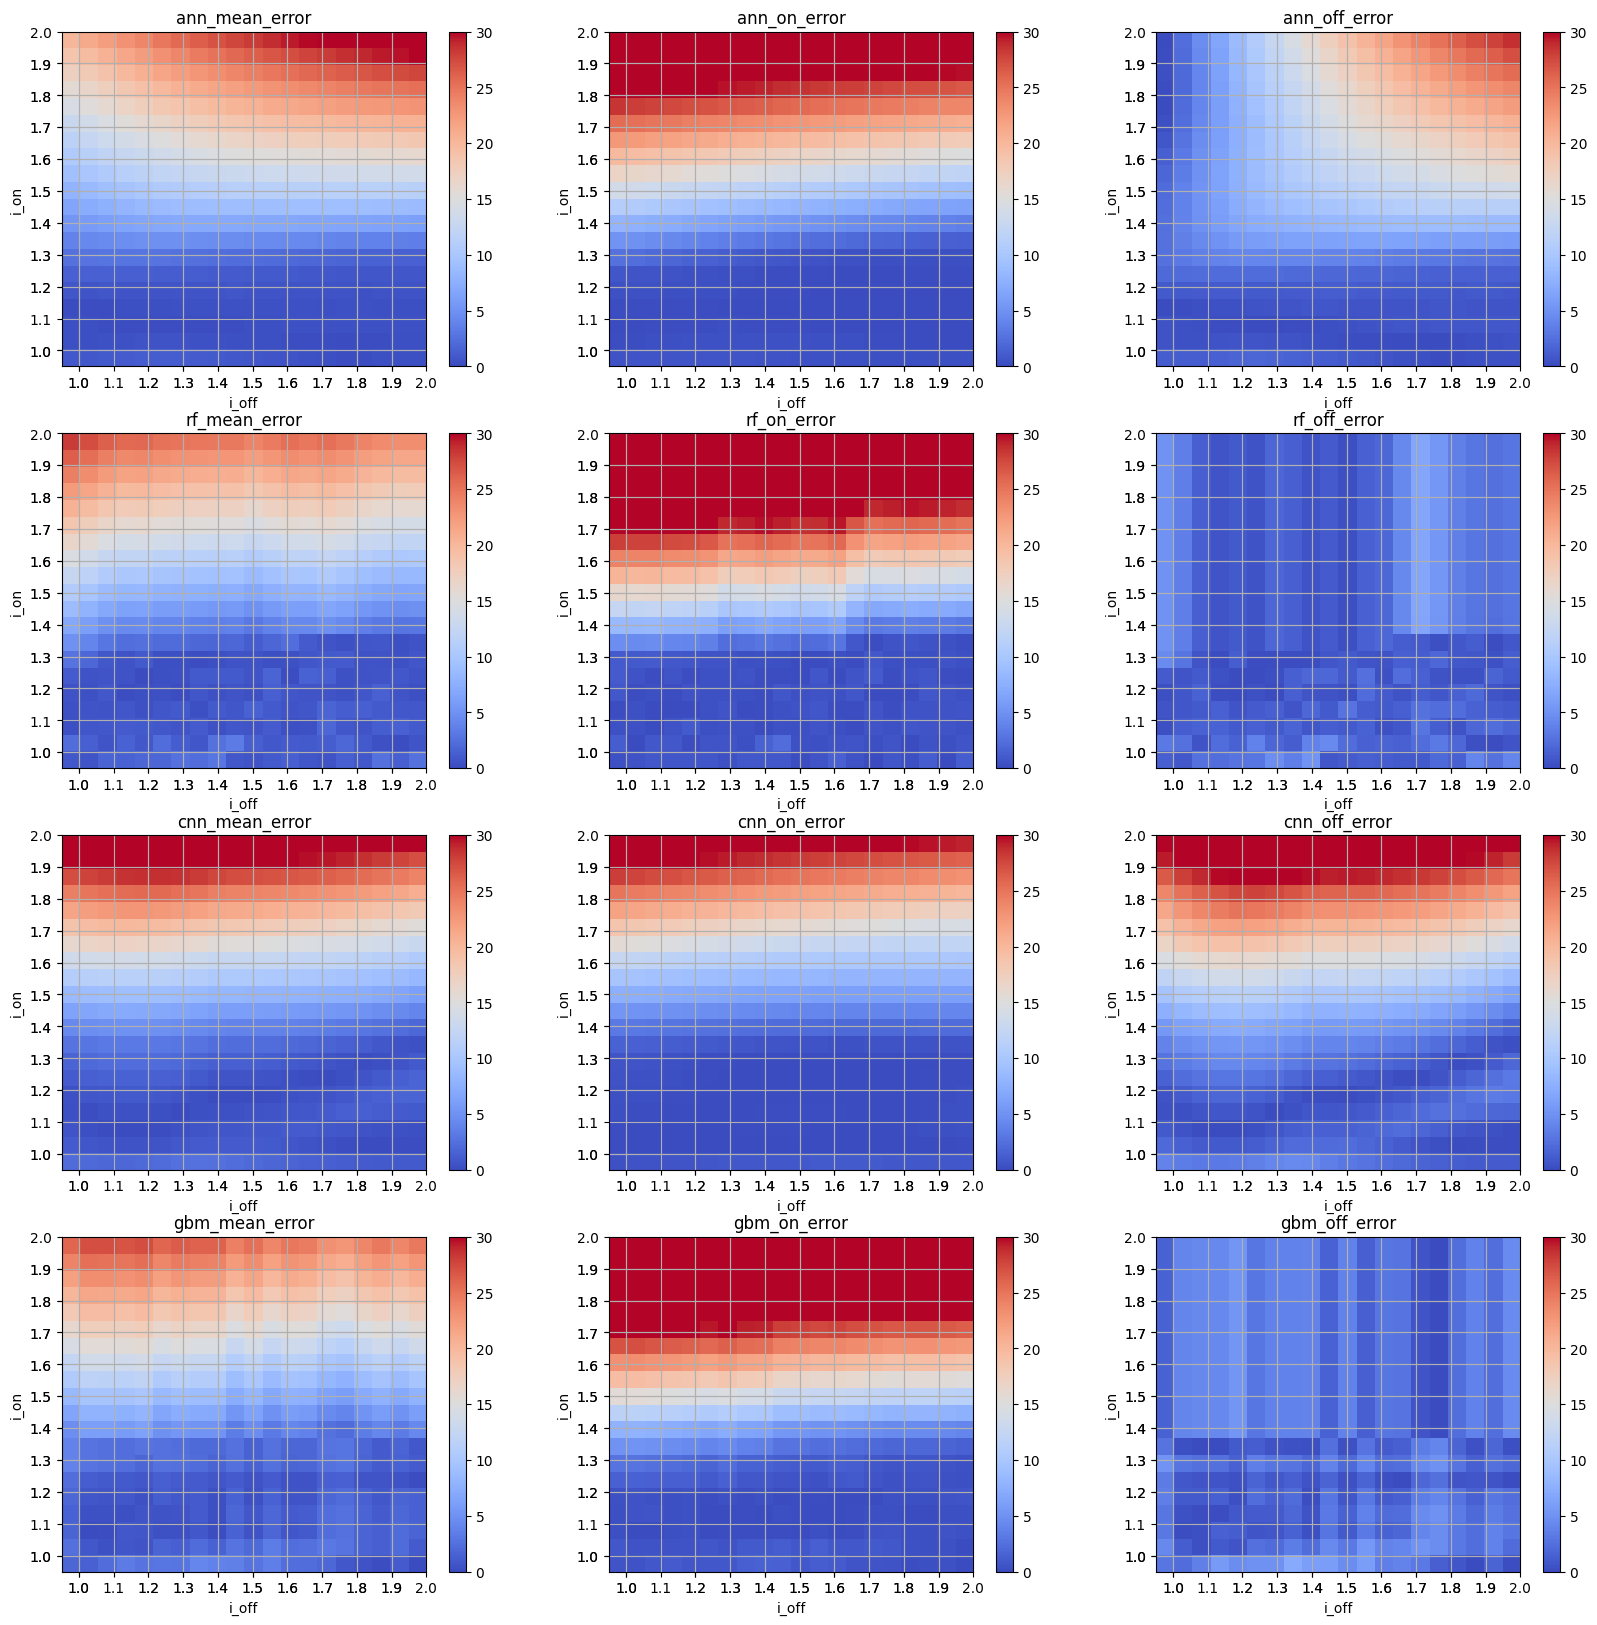

In [17]:
# 결과를 heatmap으로 표현한다.

import matplotlib.pyplot as plt
import pandas as pd, numpy as np

result_df = pd.read_csv('result.csv')
one_side_of_square = (len(result_df)) ** 0.5
if one_side_of_square != int(one_side_of_square):
    raise ValueError("i_on, i_off의 개수가 정사각형이 아님: ", len(result_df))

i_on_original = result_df['i_on']
i_off_original = result_df['i_off']

fig: plt.Figure = None
ax: plt.Axes = None
fig, ax = plt.subplots(len(model_names), 3, figsize=(20, 5 * len(model_names)))

for name, index in zip(model_names, range(len(model_names))):
    params = result_df[[column + '_' + name for column in output_feature]]
    i_on = result_df['i_on_' + name]
    i_off = result_df['i_off_' + name]

    mean_error = (np.abs((i_on_original - i_on) / i_on) + np.abs((i_off_original - i_off) / i_off)) / 2 * 100
    mean_error = mean_error.values.reshape((int(one_side_of_square), int(one_side_of_square)))

    on_error = np.abs((i_on_original - i_on) / i_on) * 100
    off_error = np.abs((i_off_original - i_off) / i_off) * 100
    on_error = on_error.values.reshape((int(one_side_of_square), int(one_side_of_square)))
    off_error = off_error.values.reshape((int(one_side_of_square), int(one_side_of_square)))

    # 결과를 heatmap으로 표현한다.
    mag = np.arange(1.0, 2, 0.05)
    if len(mag) != one_side_of_square:
        raise ValueError("mag와 i_on, i_off의 개수가 다름: ", len(mag), one_side_of_square)

    # heatmap 변수 설정
    extent = [mag[0] - 0.05, mag[-1] + 0.05, mag[0] - 0.05, mag[-1] + 0.05]
    vmin, vmax = 0, 30
    origin = 'lower'
    mag = np.round(mag, 1)

    # 각 행마다 mean_error, on_error, off_error의 세 가지 heatmap을 그린다.
    im_ann = ax[index, 0].imshow(mean_error, cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax, extent=extent, origin=origin)
    ax[index, 0].set_xticks(mag)
    ax[index, 0].set_yticks(mag)
    ax[index, 0].set_xticklabels(mag)
    ax[index, 0].set_yticklabels(mag)
    ax[index, 0].set_xlabel('i_off')
    ax[index, 0].set_ylabel('i_on')
    ax[index, 0].set_title(name + '_mean_error')
    ax[index, 0].grid(True)
    fig.colorbar(im_ann, ax=ax[index, 0])

    im_rf = ax[index, 1].imshow(on_error, cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax, extent=extent, origin=origin)
    ax[index, 1].set_xticks(mag)
    ax[index, 1].set_yticks(mag)
    ax[index, 1].set_xticklabels(mag)
    ax[index, 1].set_yticklabels(mag)
    ax[index, 1].set_xlabel('i_off')
    ax[index, 1].set_ylabel('i_on')
    ax[index, 1].set_title(name + '_on_error')
    ax[index, 1].grid(True)
    fig.colorbar(im_rf, ax=ax[index, 1])

    im_rf = ax[index, 2].imshow(off_error, cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax, extent=extent, origin=origin)
    ax[index, 2].set_xticks(mag)
    ax[index, 2].set_yticks(mag)
    ax[index, 2].set_xticklabels(mag)
    ax[index, 2].set_yticklabels(mag)
    ax[index, 2].set_xlabel('i_off')
    ax[index, 2].set_ylabel('i_on')
    ax[index, 2].set_title(name + '_off_error')
    ax[index, 2].grid(True)
    fig.colorbar(im_rf, ax=ax[index, 2])

plt.savefig('heatmap.png')